# **<span style="color:red">Solutions 2</span>**

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2025

***

# 1.

## Swaption Vol Data

The file `data/swaption_vol_data_2025-01-31.xlsx` has market data on the implied volatility skews for swaptions. Note that it has several columns:
* `expry`: expiration of the swaption
* `tenor`: tenor of the underlying swap
* `model`: the model by which the volatility is quoted. (All are Black.)
* `-200`, `-100`, etc.: The strike listed as difference from ATM strike (bps). Note that ATM is considered to be the **forward swapa rate** which you can calculate.

Your data: ywill use a single row of this data for the `1x4` swaption.
* date: `2025-01-31`
* expiration: 1yr
* tenor: 4yrs

## Rate Data

The file `data/cap_curves_2025-01-31.xlsx` gives 
* SOFR swap rates, 
* their associated discount factors
* their associated forward interest rates.

You will not need the cap data (flat or forward vols) for this problem.

## The Swaption

Consider the following swaption with the following features:
* underlying is a fixed-for-floating (SOFR) swap
* the underlying swap has **quarterly** payment frequency
* this is a **payer** swaption, which gives the holder the option to **pay** the fixed swap rate and receive SOFR.

### 1.1
Calculate the (relevant) forward swap rate. That is, the one-year forward 4-year swap rate.

### 1.2
Price the swaptions at the quoted implied volatilites and corresponding strikes, all using the just-calculated forward swap rate as the underlying.

### 1.3
To consider how the expiration and tenor matter, calculate the prices of a few other swaptions for comparison. 
* No need to get other implied vol quotes--just use the ATM implied vol you have for the swaption above. (Here we are just interested in how Black's formula changes with changes in tenor and expiration.)
* No need to calculate for all the strikes--just do the ATM strike.

Alternate swaptions
* The 3mo x 4yr swaption
* The 2yr x 4yr swaption
* the 1yr x 2yr swaption

Report these values and compare them to the price of the `1y x 4y` swaption.

***

# **<span style="color:red">Solutions</span>**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import date
from datetime import datetime

import sys
sys.path.insert(0, '../cmds')
from ficcvol import *
from ratecurves import *
from treasury_cmds import compound_rate
from volskew import *

In [2]:
import datetime
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import matplotlib.ticker as mtick
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

# **<span style="color:red">Solution 1</span>**

In [3]:
DATE = '2025-01-31'
freqcurve = 4

SWAP_TYPE = 'SOFR'
QUOTE_STYLE = 'black'
RELATIVE_STRIKE = 0

expry = 1
tenor = 4

freqswap = 4
isPayer=True
N = 100

In [4]:
curves = pd.read_excel(f'../data/cap_curves_{DATE}.xlsx', sheet_name=f'rate curves {DATE}').set_index('tenor')

Topt = expry
Tswap = Topt+tenor

fwdrate = curves['forwards'][Topt]

fwdswap = calc_fwdswaprate(curves['discounts'], Topt, Tswap, freqswap=freqswap)

## **<span style="color:red">1.1</span>**

In [5]:
display(f'The forward swap rate is {fwdswap:.2%}')

'The forward swap rate is 3.94%'

## **<span style="color:red">1.2</span>**

### Import and Process Quoted Vols

In [6]:
voldata = pd.read_excel(f'../data/swaption_vol_data_{DATE}.xlsx')
volquote = voldata.query(f'model=="{QUOTE_STYLE}"').query(f'reference=="{SWAP_TYPE}"').query(f'date=="{DATE}"')
idx = (volquote['expiration']==expry) & (volquote['tenor']==tenor)
volquote = volquote.loc[idx]
volquote.index = ['implied vol']

volquote

,reference,instrument,model,date,expiration,tenor,-200,-100,-50,-25,0,25,50,100,200
implied vol,SOFR,swaption,black,2025-01-31,1,4,42.13,31.51,28.15,26.89,25.9,25.16,24.66,24.23,24.73


In [7]:
strikerange = np.array(volquote.columns[-9:].tolist())
vols = volquote[strikerange]
vols /= 100
strikes = fwdswap + strikerange/100/100
idstrike = np.where(strikerange==RELATIVE_STRIKE)[0][0]

idstrikeATM = np.where(strikerange==0)[0][0]

if QUOTE_STYLE == 'normal':
    vols /= 100 * fwdrate

capvol = curves.loc[Topt,'fwd vols']

strikeATM = strikes[idstrikeATM]
volATM = vols.iloc[0,idstrikeATM]

### Use Black's Formula

In [8]:
period_fwd = curves.index.get_loc(Topt)
period_swap = curves.index.get_loc(Tswap)+1
step = round(freqcurve/freqswap)

discount = curves['discounts'].iloc[period_fwd+step : period_swap : step].sum()/freqswap
blacks_quotes = vols.copy()
blacks_quotes.loc['price'] = N * blacks_formula(Topt,vols,strikes,fwdswap,discount,isCall=isPayer)[0]
blacks_quotes.loc['strike'] = strikes
blacks_quotes = blacks_quotes.loc[['strike','implied vol','price']]

blacks_quotes.style.format('{:.2%}').format('{:.2f}',subset=pd.IndexSlice['price',:])

,-200,-100,-50,-25,0,25,50,100,200
strike,1.94%,2.94%,3.44%,3.69%,3.94%,4.19%,4.44%,4.94%,5.94%
implied vol,42.13%,31.51%,28.15%,26.89%,25.90%,25.16%,24.66%,24.23%,24.73%
price,7.16,3.90,2.51,1.93,1.44,1.04,0.74,0.36,0.08


## **<span style="color:red">1.3</span>**

In [9]:
expiries = [.25,1,2,1]
tenors = [4,4,4,2]
fwdswaps = np.full(len(expiries),np.nan)

blacks_quotes_alt = pd.DataFrame(dtype=float,columns=['expiry','tenor','price'])
    
for i in range(len(fwdswaps)):
    fwdswaps[i] = calc_fwdswaprate(curves['discounts'], expiries[i], expiries[i]+tenors[i], freqswap=freqswap)
    
    period0 = curves.index.get_loc(expiries[i])
    period1 = curves.index.get_loc(expiries[i]+tenors[i])+1
    step_i = round(freqcurve/freqswap)

    discount_i = curves['discounts'].iloc[period0+step_i : period1 : step_i].sum()/freqswap

    blacks_quotes_alt.loc[i,['expiry','tenor']] = [expiries[i],tenors[i]]
    blacks_quotes_alt.loc[i,'price'] = N * blacks_formula(expiries[i],volATM,strikeATM,fwdswaps[i],discount_i,isCall=isPayer)

    
def highlight_row(row):
    if row.name == 1:
        return ['background-color: gray'] * len(row)
    else:
        return [''] * len(row)
    
blacks_quotes_alt.style.apply(highlight_row,axis=1).format({'expiry':'{:.2f}', 'tenor':'{:.2f}', 'price':'{:.2f}'})

,expiry,tenor,price
0,0.25,4.00,0.76
1,1.00,4.00,1.44
2,2.00,4.00,2.03
3,1.00,2.00,0.70


***

# 2. SABR Volatility Modeling

Use the quoted volatility skew to fit a SABR model.
* Throughout, parameterize, `beta=.75`.

### 2.1.
Estimate $(\alpha,\rho,\nu)$ via the SABR formula. Feel free to use the `sabr` function in `cmds/volskew.py`.

Report the values of these parameters.

### 2.2.
Create a grid of strikes of `[.0025, .09]`, with grid spacing of `10bps`, (.0010).

Use the SABR model parameterized above to calculate the volatility for each of these strikes.

* Plot the SABR curve, and also include the market quotes in the plot.

* Conceptually, does the SABR curve fit these points well? Perfectly?

### 2.3.
Suppose we want to price the `1y4y` swaption but with a far out-of-the-money strike of `5%`. 

* Use the SABR vol at this strike to price the swaption.

(Note that this strike is far outside the range for which we have market quotes, and even if we do have quotes, they likely are not liquid on a given day.)



### 2.4.

Use the ATM implied volatility to fit $\alpha$, (sometimes denoted $\sigma_0$.) That is, for any choice of $(\rho,\nu)$, solve a quadratic equation to get $\alpha$ as a function of those two parameters, along with $\beta$, which is at its selected (not estimated) value.

Recall that we have a simple relationship between ATM vol and $\alpha$.
$$\sigma_\text{ATM} = \alpha\frac{B}{F^{1-\beta}}$$
where $B$ is defined in the discussion note. It is a quadratic expression of $\alpha$ along with $(\beta,\rho,\nu)$.

This decouples the optimization. We solve for $(\rho,\nu)$ and $\alpha$ as a function of the other two parameters.

Consider using the function `sabrATM` in `cmds/volskew.py`.

***

# **<span style="color:red">Solution 2</span>**

In [25]:
def obj_fun(xargs):
    nu = xargs[0]
    rho = xargs[1]
    alpha = xargs[2]
    
    ivolSABR = np.zeros(len(strikes))
    
    for i,strike in enumerate(strikes):
         ivolSABR[i] = sabr(BETA,nu,rho,alpha,F,strike,Topt)
    
    error = ((ivolSABR - vols.values)**2).sum()
    
    return error


def obj_fun_slim(xargs):
    nu = xargs[0]
    rho = xargs[1]
    ivolSABR = np.zeros(len(strikes))
    
    for i,strike in enumerate(strikes):
         ivolSABR[i] = sabr_slim(BETA,nu,rho,F,strike,Topt,volATM)
    
    error = ((ivolSABR - vols.values)**2).sum()
    
    return error

In [26]:
doSLIM = False
BETA = 0.75
F = fwdswap-1e-8

In [27]:
vols

,-200,-100,-50,-25,0,25,50,100,200
implied vol,0.4213,0.3151,0.2815,0.2689,0.259,0.2516,0.2466,0.2423,0.2473


In [28]:
volATM

0.259

In [29]:
if not doSLIM:
    x0 = np.array([.6,0,.1])
    fun = obj_fun
else:
    fun = obj_fun_slim
    x0 = np.array([.6,0,.1])

optim = minimize(fun,x0)
xstar = optim.x
nustar = xstar[0]
rhostar = xstar[1]
   
if doSLIM:
    alphastar = solve_alpha(BETA,nustar,rhostar,Topt,volATM,F)
    ivolSABR = sabr_slim(BETA,nustar,rhostar,F,strikes,Topt,volATM)
else:
    alphastar = xstar[2]
    ivolSABR = sabr(BETA,nustar,rhostar,alphastar,F,strikes,Topt)
    
error = optim.fun

### **<span style="color:red">2.1</span>**

In [30]:
param = pd.DataFrame([BETA,alphastar,nustar,rhostar,error],index=['beta ($\\beta$)','alpha ($\\alpha$)','nu ($\\nu$)','rho ($\\rho$)','fit error'],columns=['SABR Parameters']).style.format('{:.4f}')
param

,SABR Parameters
beta ($\beta$),0.7500
alpha ($\alpha$),0.1128
nu ($\nu$),0.6914
rho ($\rho$),-0.3448
fit error,0.0000


### **<span style="color:red">2.2</span>**

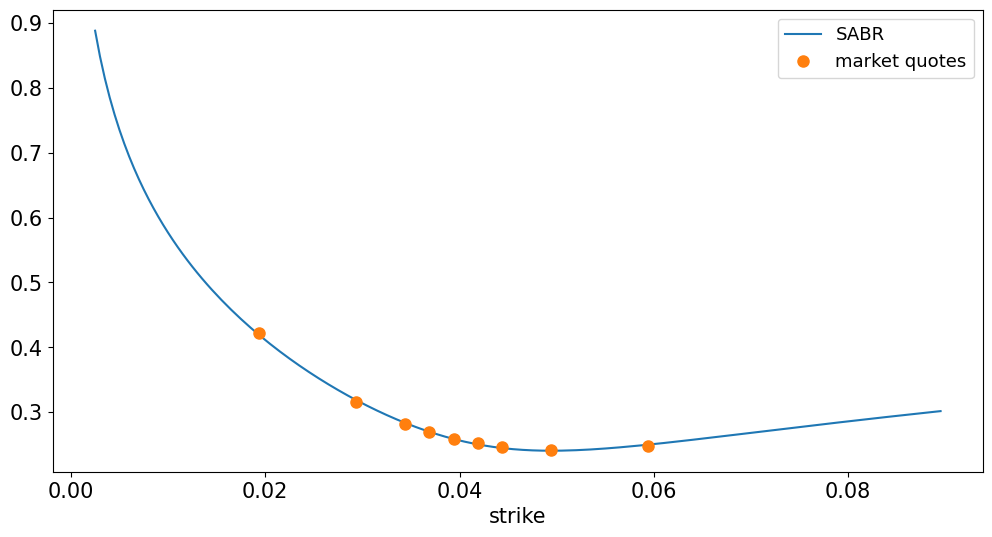

In [31]:
strikegrid = np.arange(.0025,.09,.0005)
if doSLIM:
    ivolgrid = sabr_slim(BETA,nustar,rhostar,F,strikegrid,Topt,volATM)
else:
    ivolgrid = sabr(BETA,nustar,rhostar,alphastar,F,strikegrid,Topt)
    
sabrcurve = pd.DataFrame(ivolgrid,index=strikegrid,columns=['SABR'])

volquotes = vols.copy()
volquotes.loc['strike'] = strikes
volquotes = volquotes.T.set_index('strike').rename(columns={'implied vol':'market quotes'})

fig, ax = plt.subplots()
sabrcurve.plot(ax=ax)
volquotes.plot(linestyle='',marker='o',markersize=8,ax=ax)
plt.legend();

### **<span style="color:red">2.3</span>**

In [32]:
NEWSTRIKE = .05

if doSLIM:
    newvol = sabr_slim(BETA,nustar,rhostar,F,NEWSTRIKE,Topt,volATM)
else:
    newvol = sabr(BETA,nustar,rhostar,alphastar,F,NEWSTRIKE,Topt)

newprice = N * blacks_formula(Topt,newvol,NEWSTRIKE,fwdswap,discount,isCall=isPayer)
display(f'Price of the OTM swaption at strike {NEWSTRIKE:.2%} is ${newprice:.4f}.')

'Price of the OTM swaption at strike 5.00% is $0.3179.'

### **<span style="color:red">2.4</span>**

Set the parameter `doSLIM` to `True`, and rerun the code.

***

# 3. SABR and Risk Management

Consider how an **increase** of `50bps` in the underlying rate impacts the price of the `1y4y` ATM swaption.

Here, we are assuming that
* the rate change will impact the forward swap rate directly, one-for-one with other rates.
* the shift happens one week after the original quote date.

Of course, in reality, a rate change
* may price in early to some degree if it is expected
* may not impact the forward swap rate one-for-one. We would need to model how the discount curve changes and what that change (level, slope, curvature?) would do to the forward swap rate.

### 3.1

Use Black's equation to re-price the `1y4y` swaption with
* the same ATM volatility
* an underlying (forward swap) rate `increased` `50bps`.
* the same time-to-maturities. (We should decrease these all by 1/365, but we focus here on the delta effects rather than the theta. And it would be a small impact anyone.)

Report 
* the new price
* the change in price divided by `50bps`, (a numerical delta.)

### 3.2

Now, we consider how the volatility may change with the underlying shift `up` of `50bps`.

Using the same SABR parameters from `2.1`, and the strike grid from `2.2`, plot the new SABR curve accounting for the underlying rate shifting `up` `50bps`.

### 3.3

Calculate the new volatility specifically for the pre-shift ATM strike.

Use this in Black's formula similar to `3.1`, where the only change is the volatility now reflects the shift in the underlying (not the strike).

Report
* the new price
* the change in price divided by `50bps`

### 3.4

How much different is the (dynamic) delta which accounts for the shift in volatility from the (static) delta in `3.1`?

***

# **<span style="color:red">Solution 3</span>**

### **<span style="color:red">3.1</span>**

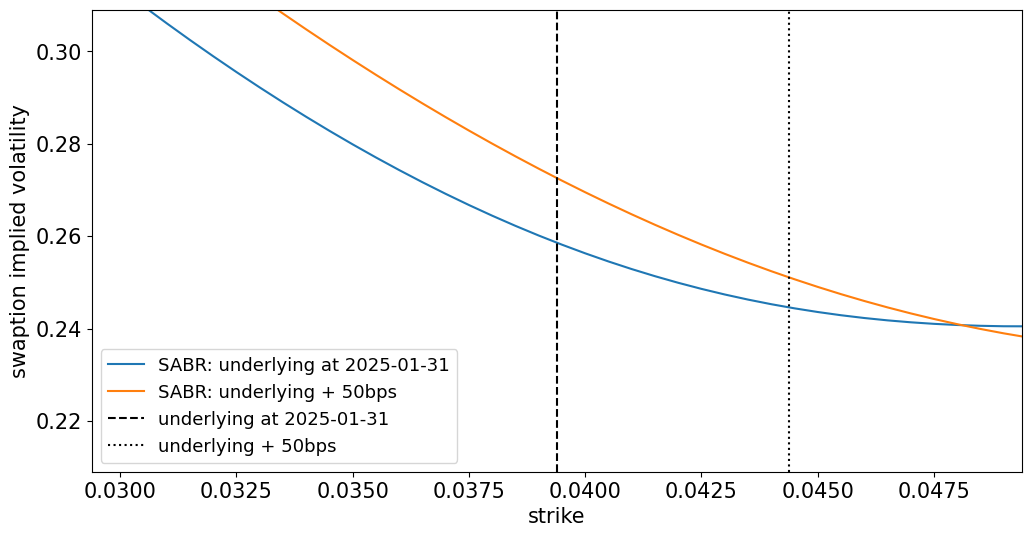

In [ ]:
warnings.filterwarnings('ignore')

SHIFT = +50/100/100

sabrcurve.rename(columns={'SABR':f'SABR: underlying at {DATE}'},inplace=True)
if doSLIM:
    sabrcurve[f'SABR: underlying + {SHIFT*100*100:.0f}bps'] = sabr_slim(BETA,nustar,rhostar,F+SHIFT,strikegrid,Topt,volATM)
else:
    sabrcurve[f'SABR: underlying + {SHIFT*100*100:.0f}bps'] = sabr(BETA,nustar,rhostar,alphastar,F+SHIFT,strikegrid,Topt)

fig, ax = plt.subplots()
sabrcurve.plot(ax=ax)
plt.xlim([F-.01,F+.01])
plt.ylim([volATM-.05,volATM+.05])
plt.axvline(F,color='k',linestyle='--',label=f'underlying at {DATE}')
plt.axvline(F+SHIFT,color='k',linestyle=':',label=f'underlying + {SHIFT*100*100:.0f}bps')
plt.ylabel('swaption implied volatility');
plt.xlabel('strike')
plt.legend();

### **<span style="color:red">3.2, 3.3, 3.4</span>**

In [36]:
idloc = (sabrcurve.index.to_series()-fwdswap).abs().idxmin()

newvols = sabrcurve.loc[idloc]
strikeATM = strikes[idstrikeATM]

Frange = F + [0,SHIFT]

In [18]:
period_fwd = curves.index.get_loc(Topt)
period_swap = curves.index.get_loc(Tswap)+1
step = round(freqcurve/freqswap)

discount = curves['discounts'].iloc[period_fwd+step : period_swap : step].sum()/freqswap

blackprices = pd.Series(N * blacks_formula(Topt, newvols[0],NEWSTRIKE,Frange,discount,isCall=isPayer), index=['no change in rates','shift in rates'], name='no change in vol').to_frame().T
blackprices.loc['dynamic vol','shift in rates'] = N * blacks_formula(Topt, newvols[1],NEWSTRIKE,Frange[1],discount,isCall=isPayer)
blackprices.style.format('{:.2f}')

,no change in rates,shift in rates
no change in vol,0.39,0.90
dynamic vol,nan,0.98


In [19]:
dprices = (blackprices[['shift in rates']] - blackprices.loc['no change in vol','no change in rates']).rename(columns={'shift in rates':'price change'})
delta = dprices / SHIFT
delta.style.format('{:.2f}')

,price change
no change in vol,102.52
dynamic vol,119.04


In [20]:
delta_relative_change = delta.pct_change().loc['dynamic vol','price change']
display(f'Relative change to delta: {delta_relative_change : .2%}.')

'Relative change to delta:  16.11%.'

In [ ]:
print(f"Model ")